In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [46]:
df = pd.read_csv("train.csv")

In [47]:
df.head()

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,Heating,Condition2,...,GarageCars,KitchenQual,KitchenAbvGr,GrLivArea,2ndFlrSF,CentralAir,BsmtQual,TotalBsmtSF,Fireplaces,SalePrice
0,Lvl,2003.0,2,856,706,8,Gd,61,GasA,Norm,...,2,Gd,1,1710,854,Y,Gd,856,0,208500
1,Lvl,1976.0,2,1262,978,6,TA,0,GasA,Norm,...,2,TA,1,1262,0,Y,Gd,1262,1,181500
2,Lvl,2001.0,2,920,486,6,Gd,42,GasA,Norm,...,2,Gd,1,1786,866,Y,Gd,920,1,223500
3,Lvl,1998.0,1,961,216,7,TA,35,GasA,Norm,...,3,Gd,1,1717,756,Y,TA,756,1,140000
4,Lvl,2000.0,2,1145,655,9,Gd,84,GasA,Norm,...,3,Gd,1,2198,1053,Y,Gd,1145,1,250000


<h3>Проверяю типы данных и размер датафрейма</h3>

In [48]:
df.dtypes

LandContour      object
GarageYrBlt     float64
FullBath          int64
1stFlrSF          int64
BsmtFinSF1        int64
TotRmsAbvGrd      int64
ExterQual        object
OpenPorchSF       int64
Heating          object
Condition2       object
OverallQual       int64
GarageCars        int64
KitchenQual      object
KitchenAbvGr      int64
GrLivArea         int64
2ndFlrSF          int64
CentralAir       object
BsmtQual         object
TotalBsmtSF       int64
Fireplaces        int64
SalePrice         int64
dtype: object

In [49]:
df.shape

(1460, 21)

In [50]:
df.isna().sum()

LandContour      0
GarageYrBlt     81
FullBath         0
1stFlrSF         0
BsmtFinSF1       0
TotRmsAbvGrd     0
ExterQual        0
OpenPorchSF      0
Heating          0
Condition2       0
OverallQual      0
GarageCars       0
KitchenQual      0
KitchenAbvGr     0
GrLivArea        0
2ndFlrSF         0
CentralAir       0
BsmtQual        37
TotalBsmtSF      0
Fireplaces       0
SalePrice        0
dtype: int64

<Axes: xlabel='GarageYrBlt', ylabel='Count'>

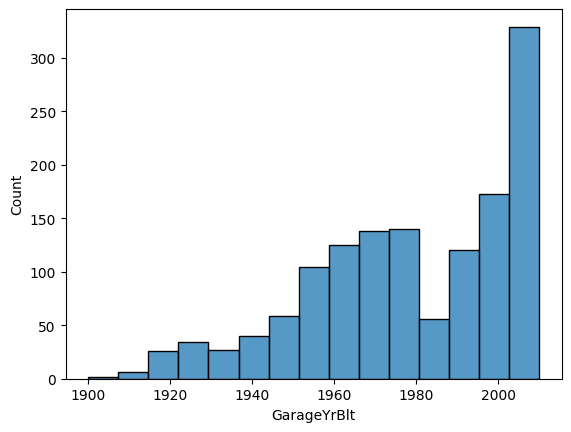

In [51]:
sns.histplot(df["GarageYrBlt"])

<h4>Пропуски в GarageYrBlt могу заполнить медианным(1980). Можно и средним(~1979)</h4>

In [52]:
df["GarageYrBlt"].fillna(df["GarageYrBlt"].median(), inplace=True)

In [53]:
df["BsmtQual"].value_counts()

BsmtQual
TA    649
Gd    618
Ex    121
Fa     35
Name: count, dtype: int64

Пропуски в BsmtQual заполню наиболее часто встречающимся значением</br>
TA	Average/Typical</br>

In [54]:
df["BsmtQual"] = df["BsmtQual"].fillna(df["BsmtQual"].value_counts().index[0])

In [55]:
df.isna().sum().unique()#Пропусков больше нет

array([0], dtype=int64)

In [56]:
df.shape#Размер не изменился - отлично

(1460, 21)

<h4>Есть ли коррелирующие признаки?</h4>

<Axes: >

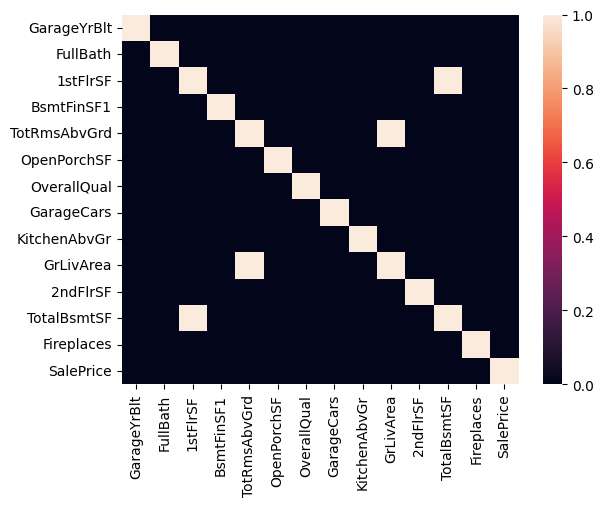

In [57]:
sns.heatmap(df.corr(numeric_only=True)>0.8)

<h3>Видно, что признаки 1stFlrSF и TotalBsmtSF имеют достаточно сильную корреляцию</br>
Также сильную корреляцию имеют GrLivArea и TotRmsAbvGrd</h3>

<h3>Посмотрим на распределение цен на жилье</h3>

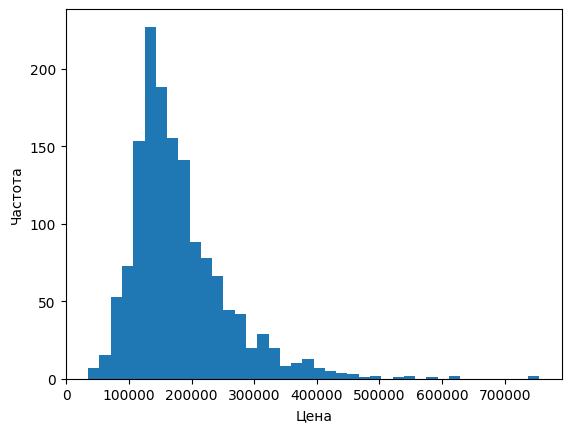

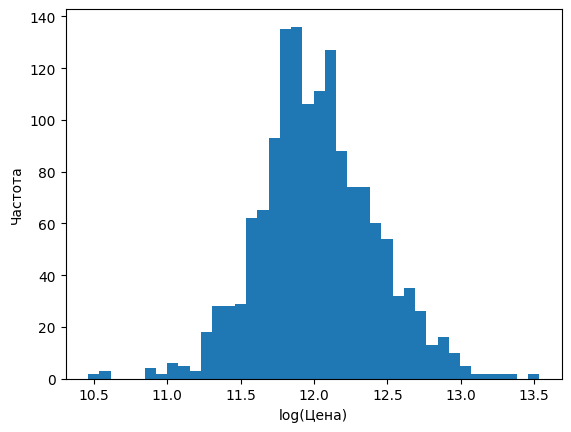

In [58]:
#fig = plt.figure(figsize=(20,8))
plt.hist(df["SalePrice"], bins = 40)
plt.ylabel("Частота")
plt.xlabel("Цена")
plt.show()

#fig = plt.figure(figsize=(20,8))
plt.hist(np.log1p(df["SalePrice"]), bins = 40)
plt.ylabel("Частота")
plt.xlabel("log(Цена)");

<h2>Я буду работать с логарифмом, т.к. распределение больше походит на нормально, чем изначальное</h2>

Подготавливаю данные для CatBoost

In [59]:
X = df.drop(columns="SalePrice")
y = np.log1p(df["SalePrice"])
cat_columns = X.columns[X.dtypes == "object"].values
numeric_columns = X.columns[X.dtypes != "object"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [60]:
cb_reg = CatBoostRegressor(iterations=500, eval_metric="RMSE",
                           task_type="GPU", random_seed=42)
params = {
    "verbose": 100,
    "eval_set": (X_test, y_test),
    "use_best_model": True,
    "cat_features": cat_columns,
    "plot": True,
    }
cb_reg.fit(X_train, y_train, **params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.076412
0:	learn: 0.3727829	test: 0.3961986	best: 0.3961986 (0)	total: 17.5ms	remaining: 8.75s
100:	learn: 0.1234845	test: 0.1492807	best: 0.1492807 (100)	total: 1.6s	remaining: 6.32s
200:	learn: 0.1169824	test: 0.1480502	best: 0.1476961 (151)	total: 3.1s	remaining: 4.61s
300:	learn: 0.1143059	test: 0.1481070	best: 0.1476961 (151)	total: 4.73s	remaining: 3.13s
400:	learn: 0.1131744	test: 0.1475440	best: 0.1475075 (397)	total: 6.39s	remaining: 1.58s
499:	learn: 0.1122363	test: 0.1473384	best: 0.1473288 (471)	total: 8.05s	remaining: 0us
bestTest = 0.147328777
bestIteration = 471
Shrink model to first 472 iterations.


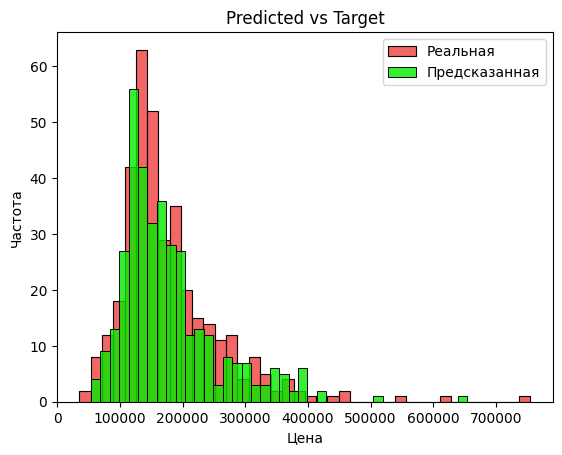

In [61]:
sns.histplot(np.expm1(y_test), label="Реальная",
             color="#eb0000", alpha=0.6, bins=40)

sns.histplot(np.expm1(cb_reg.predict(X_test)), label="Предсказанная",
             color="#04eb00", alpha=0.8, bins=40)
plt.legend()
plt.ylabel("Частота")
plt.xlabel("Цена")
plt.title("Predicted vs Target")
plt.show()

<h3>Попробуем удалить по одному из пар коррелирующих признаков</h3>

In [62]:
X = df.drop(columns=["SalePrice", "TotalBsmtSF", "TotRmsAbvGrd"])
y = np.log1p(df["SalePrice"])
cat_columns = X.columns[X.dtypes == "object"].values
numeric_columns = X.columns[X.dtypes != "object"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [63]:
cb_reg_no_corr = CatBoostRegressor(iterations=500, eval_metric="RMSE",
                           task_type="GPU", random_seed=42)
params = {
    "verbose": 100,
    "eval_set": (X_test, y_test),
    "use_best_model": True,
    "cat_features": cat_columns,
    "plot": True,
    }
cb_reg_no_corr.fit(X_train, y_train, **params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.076412
0:	learn: 0.3730601	test: 0.3960465	best: 0.3960465 (0)	total: 17.9ms	remaining: 8.92s
100:	learn: 0.1257592	test: 0.1520744	best: 0.1520699 (99)	total: 1.57s	remaining: 6.21s
200:	learn: 0.1184301	test: 0.1502301	best: 0.1499439 (180)	total: 3.13s	remaining: 4.66s
300:	learn: 0.1162389	test: 0.1504913	best: 0.1499439 (180)	total: 4.76s	remaining: 3.15s
400:	learn: 0.1151251	test: 0.1507245	best: 0.1499439 (180)	total: 6.45s	remaining: 1.59s
499:	learn: 0.1140230	test: 0.1507209	best: 0.1499439 (180)	total: 8.04s	remaining: 0us
bestTest = 0.1499438542
bestIteration = 180
Shrink model to first 181 iterations.


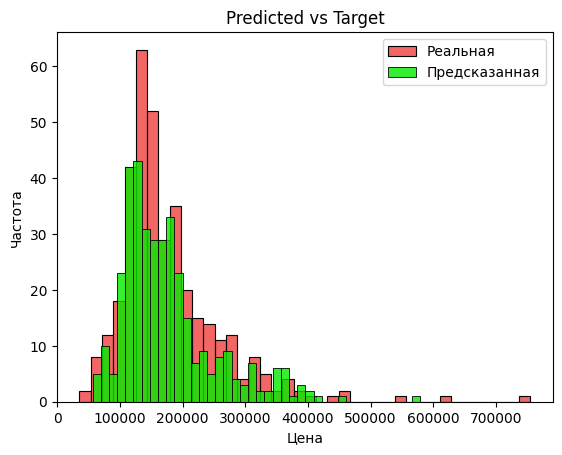

In [64]:
sns.histplot(np.expm1(y_test), label="Реальная",
             color="#eb0000", alpha=0.6, bins=40)

sns.histplot(np.expm1(cb_reg_no_corr.predict(X_test)), label="Предсказанная",
             color="#04eb00", alpha=0.8, bins=40)
plt.legend()
plt.ylabel("Частота")
plt.xlabel("Цена")
plt.title("Predicted vs Target")
plt.show()

<h2>Существенного прироста при удалении одного из пары коррелирующих признаков мы не получили</h2>

Попробуем обучить линейную регрессию

In [65]:
Scaler = StandardScaler()
X = df.drop(columns="SalePrice")
X.loc[:, numeric_columns] = Scaler.fit_transform(X.loc[:, numeric_columns])

Преобразуем категориальные переменные с помощью one_hot_encoding

In [66]:
X = pd.get_dummies(X)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [68]:
lin_reg = LinearRegression()

In [69]:
lin_reg.fit(X_train, y_train);

Посмотрим RMSE

In [70]:
np.sqrt(mean_squared_error(y_test, lin_reg.predict(X_test)))

0.15970206792276218

RMSE больше, чем у Catboost

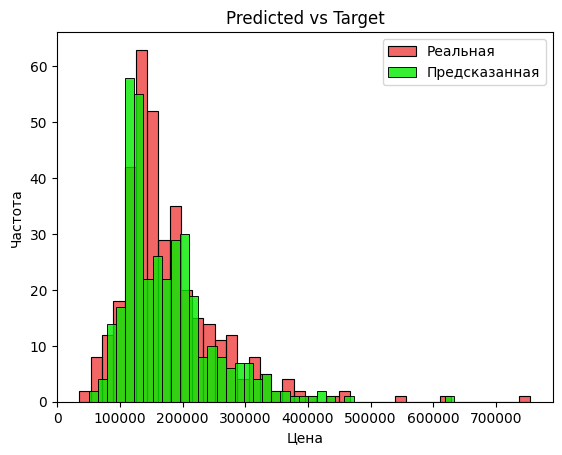

In [71]:
sns.histplot(np.expm1(y_test), label="Реальная",
             color="#eb0000", alpha=0.6, bins=40)

sns.histplot(np.expm1(lin_reg.predict(X_test)), label="Предсказанная",
             color="#04eb00", alpha=0.8, bins=40)
plt.legend()
plt.ylabel("Частота")
plt.xlabel("Цена")
plt.title("Predicted vs Target")
plt.show()

<h2>Попробуем Lasso регрессию</h2>

In [72]:
lasso_reg = Lasso(alpha=0.001)

In [73]:
lasso_reg.fit(X_train, y_train);

In [74]:
np.sqrt(mean_squared_error(y_test, lasso_reg.predict(X_test)))

0.16034830212382925

RMSE чуть больше, чем у линейной регрессии

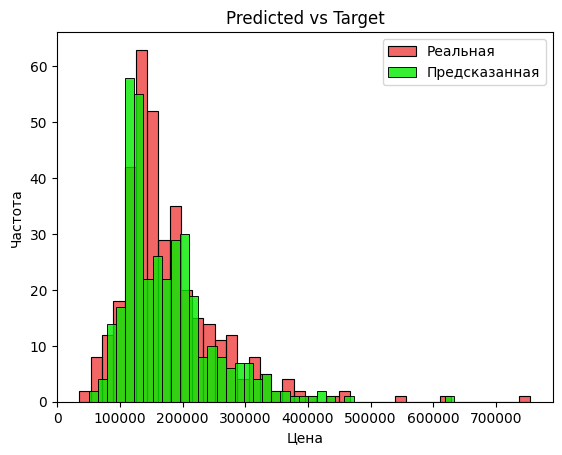

In [75]:
sns.histplot(np.expm1(y_test), label="Реальная",
             color="#eb0000", alpha=0.6, bins=40)

sns.histplot(np.expm1(lin_reg.predict(X_test)), label="Предсказанная",
             color="#04eb00", alpha=0.8, bins=40)
plt.legend()
plt.ylabel("Частота")
plt.xlabel("Цена")
plt.title("Predicted vs Target")
plt.show()

In [76]:
ridge_reg = Ridge(alpha=0.001)
ridge_reg.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, ridge_reg.predict(X_test)))

0.15970172064226468

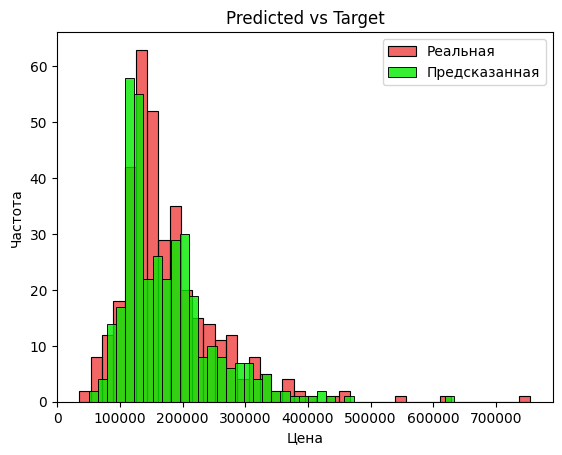

In [77]:
sns.histplot(np.expm1(y_test), label="Реальная",
             color="#eb0000", alpha=0.6, bins=40)

sns.histplot(np.expm1(ridge_reg.predict(X_test)), label="Предсказанная",
             color="#04eb00", alpha=0.8, bins=40)
plt.legend()
plt.ylabel("Частота")
plt.xlabel("Цена")
plt.title("Predicted vs Target")
plt.show()

Итого:
* CatBoost RMSE: 0.147
* Линейная регрессия без регуляризация: 0.159
* Lasso: 0.160
* Ridge: 0.159

In [78]:
test_df = pd.read_csv("test.csv")
test_df.head()

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,Heating,Condition2,OverallQual,GarageCars,KitchenQual,KitchenAbvGr,GrLivArea,2ndFlrSF,CentralAir,BsmtQual,TotalBsmtSF,Fireplaces
0,Lvl,1961.0,1,896,468.0,5,TA,0,GasA,Norm,5,1.0,TA,1,896,0,Y,TA,882.0,0
1,Lvl,1958.0,1,1329,923.0,6,TA,36,GasA,Norm,6,1.0,Gd,1,1329,0,Y,TA,1329.0,0
2,Lvl,1997.0,2,928,791.0,6,TA,34,GasA,Norm,5,2.0,TA,1,1629,701,Y,Gd,928.0,1
3,Lvl,1998.0,2,926,602.0,7,TA,36,GasA,Norm,6,2.0,Gd,1,1604,678,Y,TA,926.0,1
4,HLS,1992.0,2,1280,263.0,5,Gd,82,GasA,Norm,8,2.0,Gd,1,1280,0,Y,Gd,1280.0,0


In [79]:
test_df.shape

(1459, 20)

In [80]:
test_df.isna().sum()

LandContour      0
GarageYrBlt     78
FullBath         0
1stFlrSF         0
BsmtFinSF1       1
TotRmsAbvGrd     0
ExterQual        0
OpenPorchSF      0
Heating          0
Condition2       0
OverallQual      0
GarageCars       1
KitchenQual      1
KitchenAbvGr     0
GrLivArea        0
2ndFlrSF         0
CentralAir       0
BsmtQual        44
TotalBsmtSF      1
Fireplaces       0
dtype: int64

In [81]:
X_test = test_df.copy()
X_test["GarageYrBlt"].fillna(X_test["GarageYrBlt"].median(), inplace=True)
X_test["BsmtQual"] = X_test["BsmtQual"].fillna(X_test["BsmtQual"].value_counts().index[0])

In [82]:
X_test = X_test.bfill()#Заполняю единичные пропуски предыдущими значениями

In [83]:
predicts = np.expm1(cb_reg.predict(X_test))

In [84]:
#Индексацию сделал с 1460..2919
result_df = pd.DataFrame({"Id": list(range(df.shape[0]+1,
                                           df.shape[0]+X_test.shape[0]+1)),
                          "SalePrice": predicts})

In [85]:
result_df.to_csv("result_submission.csv", index=False)